In [97]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, gamma

import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [32]:
def make_eq(scale, noise):
    
    def eq(x1, x2, use_noise=False):

        diff = x1[:, None] - x2[None, :]
        cov = np.exp(-0.5 * (diff / scale)**2)

        if use_noise:
            cov = cov + noise**2 * np.eye(cov.shape[0])

        return cov
    
    return eq


def gp_posterior(covariance, x_train, y_train, x_pred):
    
    K_train_train = covariance(x_train, x_train, use_noise=True)
    K_pred_pred = covariance(x_pred, x_pred)
    K_train_pred = covariance(x_train, x_pred)
    K_pred_train = covariance(x_pred, x_train)
    
    mean = K_pred_train @ np.linalg.solve(K_train_train,
                                          y_train)
    
    cov = K_pred_pred - K_pred_train @ np.linalg.solve(K_train_train,
                                                       K_train_pred)
    
    return mean, cov


def make_f(loc1, scale1, loc2, scale2, a):
    
    def f(x):

        cdf = norm.cdf(x, loc=loc1, scale=scale1)

        return gamma.ppf(cdf, a=a, loc=loc2, scale=scale2)
    
    return f


def make_invf(loc1, scale1, loc2, scale2, a):
    
    def invf(x):
        
        cdf = gamma.cdf(x, a=a, loc=loc2, scale=scale2)

        return norm.ppf(cdf, loc=loc1, scale=scale1)
    
    return invf

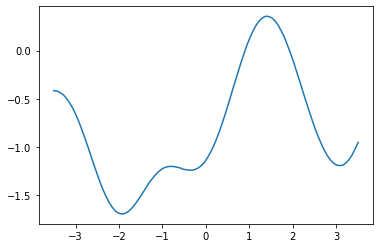

In [75]:
np.random.seed(2)

lengthscale = 1.
num_plot = 100

cov = make_eq(scale=1., noise=1e-6)

x_plot = np.linspace(-3.5, 3.5, num_plot)

K = cov(x_plot, x_plot, use_noise=False)
K = K + 1e-6 * np.eye(num_plot)
Kchol = np.linalg.cholesky(K)

y_plot = Kchol @ np.random.randn(num_plot)

plt.plot(x_plot, y_plot)
plt.show()

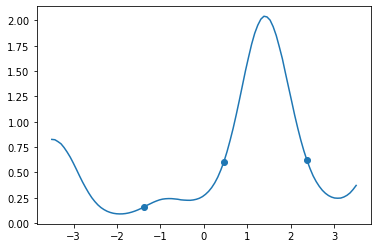

In [78]:
np.random.seed(2)

num_train = 3

loc1 = 0.
scale1 = 1.
a = 1.
loc2 = 0.
scale2 = 2.

f = make_f(loc1=loc1, scale1=scale1, a=a, loc2=loc2, scale2=scale2)
invf = make_invf(loc1=loc1, scale1=scale1, a=a, loc2=loc2, scale2=scale2)

x = x_plot
y = f(y_plot)

idx = np.random.choice(np.arange(x.shape[0]), size=(num_train,), replace=False)
x_train = x[idx]
y_train = y[idx]

plt.plot(x, y)
plt.scatter(x_train, y_train)
plt.show()

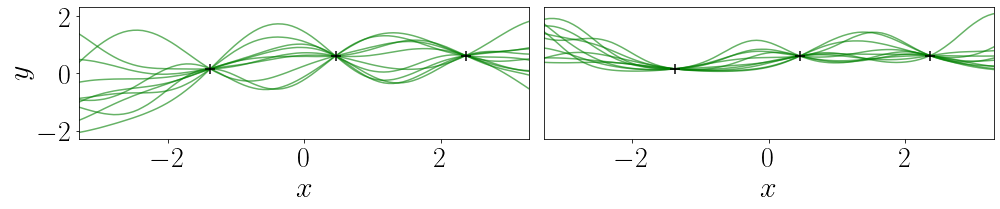

In [95]:
np.random.seed(2)
num_samples = 10

gp_mean_pred, gp_cov_pred = gp_posterior(covariance=cov,
                                         x_train=x_train,
                                         y_train=y_train,
                                         x_pred=x_plot)

ngp_mean_pred, ngp_cov_pred = gp_posterior(covariance=cov,
                                           x_train=x_train,
                                           y_train=invf(y_train),
                                           x_pred=x_plot)

Kpred_chol = np.linalg.cholesky(gp_cov_pred + 1e-6 * np.eye(num_plot))
gp_samples = gp_mean_pred[:, None] + Kpred_chol @ np.random.randn(num_plot, num_samples)
ngp_samples = ngp_mean_pred[:, None] + Kpred_chol @ np.random.randn(num_plot, num_samples)
ngp_samples = f(ngp_samples)

plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.plot(x, gp_samples, color='green', zorder=1, alpha=0.6)
plt.scatter(x_train, y_train, marker='+', c='black', zorder=2, s=100)
plt.xlim([-3.3, 3.3])
plt.ylim([-2.3, 2.3])
plt.xticks(np.linspace(-2, 2, 3), fontsize=28)
plt.yticks(np.linspace(-2, 2, 3), fontsize=28)
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$y$', fontsize=30)

plt.subplot(1, 2, 2)
plt.plot(x, ngp_samples, color='green', zorder=1, alpha=0.6)
plt.scatter(x_train, y_train, marker='+', c='black', zorder=2, s=100)
plt.xlim([-3.3, 3.3])
plt.ylim([-2.3, 2.3])
plt.yticks([])
plt.xticks(np.linspace(-2, 2, 3), fontsize=28)
plt.xlabel('$x$', fontsize=30)

plt.tight_layout()
plt.savefig('./plots/non-gaussian.pdf')
plt.show()